# KNN Jupyter Notebook


### Import Libraries

In [102]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns


### Load and Preprocess Data

In [103]:
# Load the dataset
file_path = '../Data/cleaned_heart.csv'
df = pd.read_csv(file_path)

# Convert string data to appropriate type; object -> string
string_col = df.select_dtypes(include="object").columns
df[string_col] = df[string_col].astype("string")
print(df.dtypes) # check if converted properly

Age                        int64
Sex               string[python]
ChestPainType     string[python]
RestingBP                  int64
Cholesterol                int64
FastingBS                  int64
RestingECG        string[python]
MaxHR                      int64
ExerciseAngina    string[python]
Oldpeak                  float64
ST_Slope          string[python]
HeartDisease               int64
dtype: object


### Encoding of Categorical Variables: Sex, ChestPainType, RestingECG, ExcerciseAgina, ST_Slope
Consideration of Encoding in KNN:
Distance Metric:

KNN relies on a distance metric (e.g., Euclidean distance) to find the nearest neighbors.
* Label encoding can distort the distance metric because it implies an ordinal relationship that may not exist. For example, if you have three categories "cat", "dog", "mouse" encoded as 0, 1, and 2, the algorithm might consider "mouse" closer to "dog" than "cat", which may not be meaningful.
* One-hot encoding avoids this issue by treating each category as equidistant from others.

Curse of Dimensionality:

* One-hot encoding can lead to high-dimensional data if you have many categories, which can make KNN less effective due to the curse of dimensionality.
* However, the impact of high dimensionality can be mitigated by dimensionality reduction techniques like PCA.

Thus, we use One-hot encoding to avoid distorting distance metric in KNN and use PCA to mitigate the curse of dimensionality!

### One Hot Encoding

In [104]:
# One-hot encoding of categorical variables
onehot_encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_cols = onehot_encoder.fit_transform(df[string_col])
encoded_df = pd.DataFrame(encoded_cols, columns=onehot_encoder.get_feature_names_out(string_col))

# Print one-hot encoding mappings
for col, categories in zip(string_col, onehot_encoder.categories_):
    print(f"One-hot encoding for {col}:")
    feature_names = [name for name in onehot_encoder.get_feature_names_out() if name.startswith(col)]
    for category, encoded_col in zip(categories, feature_names):
        print(f"{category} -> {encoded_col}")
    print()

One-hot encoding for Sex:
F -> Sex_M

One-hot encoding for ChestPainType:
ASY -> ChestPainType_ATA
ATA -> ChestPainType_NAP
NAP -> ChestPainType_TA

One-hot encoding for RestingECG:
LVH -> RestingECG_Normal
Normal -> RestingECG_ST

One-hot encoding for ExerciseAngina:
N -> ExerciseAngina_Y

One-hot encoding for ST_Slope:
Down -> ST_Slope_Flat
Flat -> ST_Slope_Up



In [105]:
# Drop original categorical columns and concatenate encoded columns
df = df.drop(string_col, axis=1)
df = pd.concat([df, encoded_df], axis=1)

df.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,49,160,180,0,156,1.0,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,37,130,283,0,98,0.0,0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,48,138,214,0,108,1.5,1,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
4,54,150,195,0,122,0.0,0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


### PCA (Dimensionality Reduction)

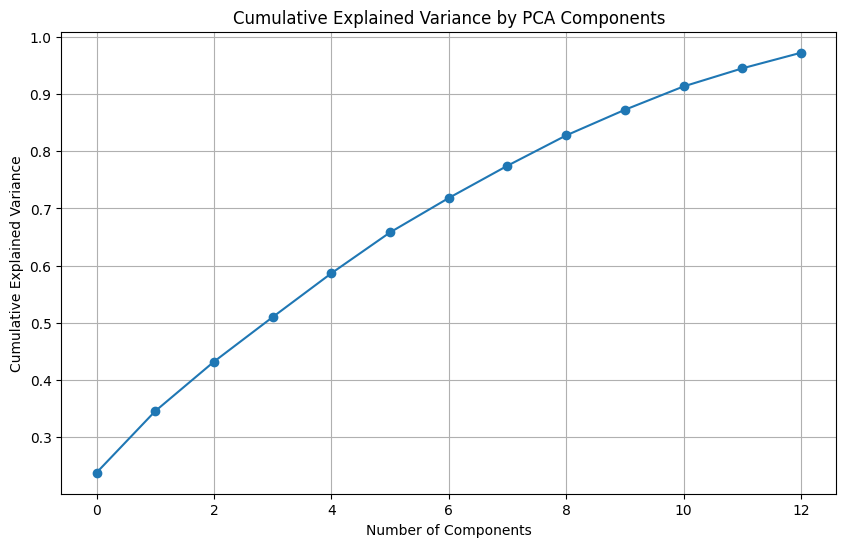

Number of components selected to retain 95% variance: 13


In [121]:
# Split the data into features and target
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

# Scale numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
# Choosing n_components to retain 95% of the variance
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

# Plot explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by PCA Components')
plt.grid(True)
plt.show()

# Print number of components selected
print(f"Number of components selected to retain 95% variance: {pca.n_components_}")


### Analysis of Feature Contributions to Principal Componenets during PCA

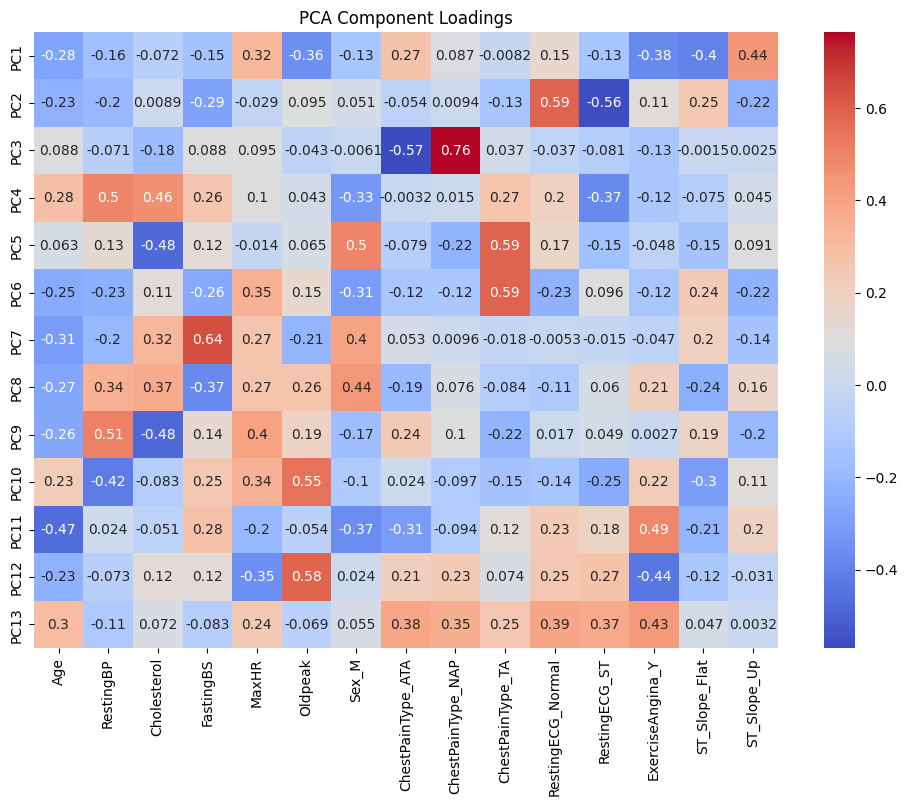

In [117]:
# Analyze feature contributions to principal components
components = pd.DataFrame(pca.components_, columns=X.columns, index=[f'PC{i+1}' for i in range(pca.n_components_)])

# Display the component loadings
# print("PCA Component Loadings:")
# print(components)

# Plot heatmap of component loadings
plt.figure(figsize=(12, 8))
sns.heatmap(components, cmap='coolwarm', annot=True)
plt.title('PCA Component Loadings')
plt.show()


This information is useful for understanding the underlying structure of the data and for making decisions about dimensionality reduction and feature selection.

The heatmap provides a visual representation of how much each original feature contributes to the principal components.

PC1 explains most variances followed by PC2, PC3 and so on. Features with high absolute loadings (either positive or negative) are more influential in the corresponding principal component.

### Train and Evalulate KNN Model

##### Note on KNN: 

K-Nearest Neighbors is a type of instance-based learning (also known as lazy learning), which has a different approach to training and prediction compared to other machine learning models.

Training in KNN:

* No Explicit Training Phase: KNN does not have a traditional training phase where the model parameters are learned from the data.
* Storage of Training Data: The "training" in KNN essentially involves storing the entire training dataset. There are no weights or parameters to update.
* Distance Computation: During prediction, KNN computes the distance between the query point and all points in the training dataset to find the k-nearest neighbors.

Prediction in KNN:

* Distance Calculation: For a given query point, KNN calculates the distance (commonly Euclidean distance) to all training points.
* Neighbor Selection: It selects the k-nearest neighbors based on the smallest distances.
* Majority Voting: In classification, KNN assigns the class that is most common among the k-nearest neighbors. In regression, it takes the average of the neighbors' values.

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.93      0.88        71
           1       0.93      0.84      0.88        79

    accuracy                           0.88       150
   macro avg       0.88      0.88      0.88       150
weighted avg       0.89      0.88      0.88       150

Confusion Matrix:
[[66  5]
 [13 66]]


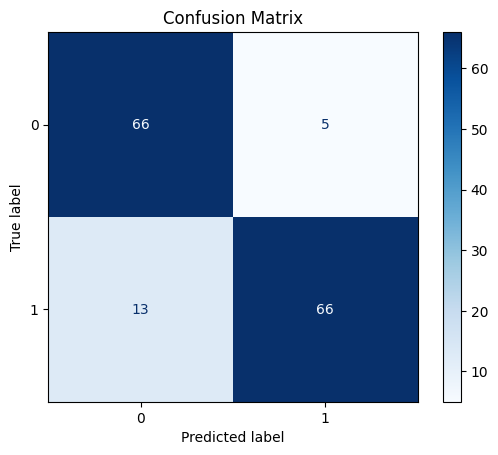

In [122]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Define the KNN model
knn = KNeighborsClassifier(n_neighbors=5)

# Fit the model
knn.fit(X_train, y_train)

# Make predictions on the test set
y_pred = knn.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


Explanation of the Classification Report:
* Precision: Precision for class 0 is 0.84, and for class 1, it is 0.93. Precision is the ratio of correctly predicted positive observations to the total predicted positives.
* Recall: Recall for class 0 is 0.93, and for class 1, it is 0.84. Recall is the ratio of correctly predicted positive observations to the all observations in the actual class.
* F1-score: F1-score for both classes is 0.88. The F1-score is the weighted average of Precision and Recall.
* Support: Support for class 0 is 71, and for class 1, it is 79. Support is the number of actual occurrences of the class in the dataset.
* Accuracy: The accuracy is the proportion of correctly predicted instances (both true positives and true negatives) among the total instances.
    
    The accuracy is calculated as:
    Accuracy
    = $\frac{TP + TN} {Total}$
    = $\frac{66 + 66} {150}$​ 
    = 0.88

* Confusion Matrix:
    True Positives (TP) for class 1: 66
    True Negatives (TN) for class 0: 66
    False Positives (FP) for class 0: 5
    False Negatives (FN) for class 1: 13

Summary:
Accuracy: 88% (or 0.88)
Precision, Recall, F1-score: Provide additional insights into the model's performance for each class, showing a balance in prediction performance for both classes.
The classification report and the confusion matrix together confirm that the model's accuracy is 88%.

### Find Optimal K

We find the optimal hyper parameter k using cross-validation which gives us an unbiased estimate of the model's performance. Cross-validation is the average accuracy of teh model on the validation folds during the cross-validation proces. This helps estimate the model's perforamnce on unseen data. 

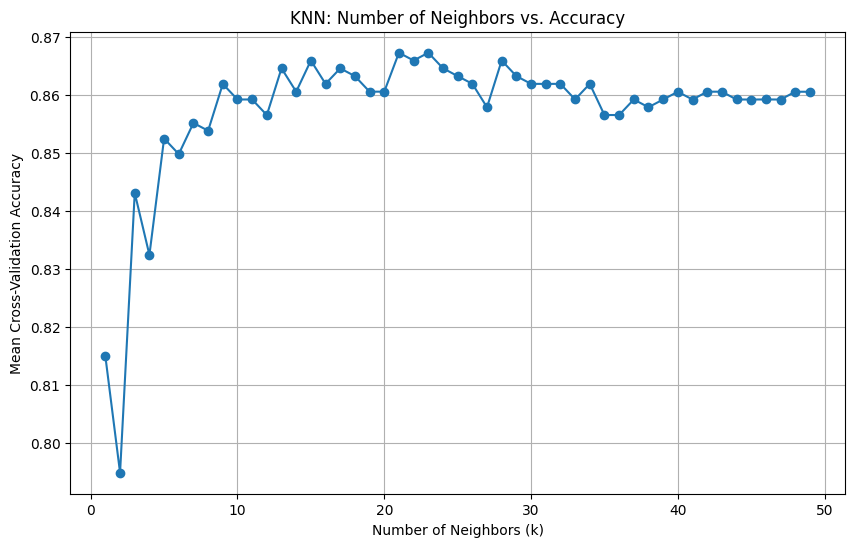

In [110]:
# Experiment with different values of k
k_values = range(1, 50)
accuracy_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    cv_scores = cross_val_score(knn, X_pca, y, cv=5, scoring='accuracy')
    accuracy_scores.append(cv_scores.mean())

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracy_scores, marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Cross-Validation Accuracy')
plt.title('KNN: Number of Neighbors vs. Accuracy')
plt.grid(True)
plt.show()


We can conclude that having 23 Number of Neighbors (k) is the optimal K value. 

While k = 23 gives us the optimal k value computed by using cross-validation, we found out that using different k values sometimes gives us better test accuracies. To explore this phenomenon, we evaluated model accuracy testing with different k values ranging from 1 to 30.

Length of k_values: 30
Length of accuracy_scores: 30
Length of test_accuracies: 30


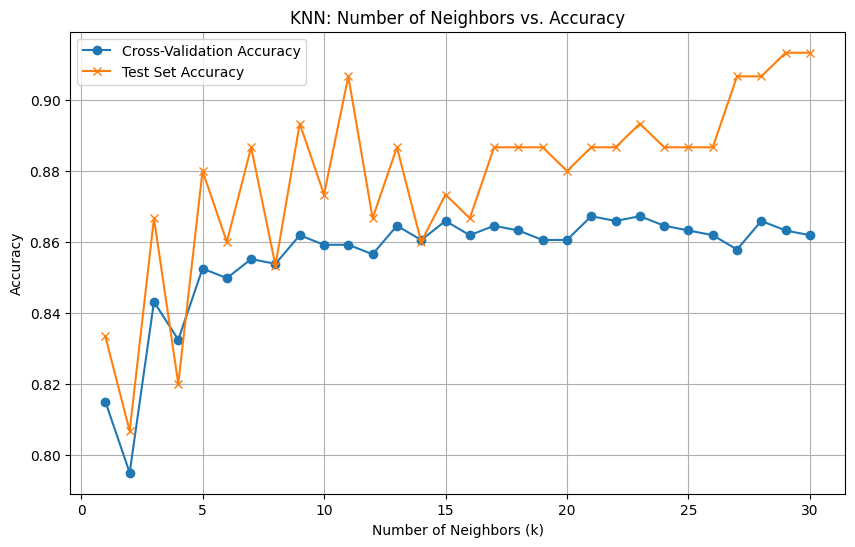

In [112]:
# Evaluate model accuracy for different values of k on the test set
k_values = range(1, 31)
accuracy_scores = []
test_accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    
    # Perform cross-validation and calculate accuracy
    cv_scores = cross_val_score(knn, X_pca, y, cv=5, scoring='accuracy')
    accuracy_scores.append(cv_scores.mean())
    
    # Fit the model and evaluate on the test set
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    test_accuracies.append(test_accuracy)

# Check if both lists have the same length
print(f"Length of k_values: {len(k_values)}")
print(f"Length of accuracy_scores: {len(accuracy_scores)}")
print(f"Length of test_accuracies: {len(test_accuracies)}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracy_scores, marker='o', label='Cross-Validation Accuracy')
plt.plot(k_values, test_accuracies, marker='x', label='Test Set Accuracy')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('KNN: Number of Neighbors vs. Accuracy')
plt.legend()
plt.grid(True)
plt.show()


As shown in the plot, we discovered that having different number of neighbors (k values) besides k = 23, leads to having better test set accuracy in some cases. 

Generally if model performs well during cross-validation, it is expected to perform well on the test set because cross-validation helps mitigate overfitting. Higher test set accuracy indicates good generalization, but it is also possible for the test accuracy to differ from the cross-validation due to the nature of data splits.

To elaborate, some possible explanations of why this is happening could be of the following reasons:
1. Randomness in Data Splits: The specific split of the training and test data can lead to variations in accuracy.
2. Overfitting: A model might overfit to the validation folds during cross-validation, resulting in slightly lower performance on the test set.
3. Sample Size: With limited data, slight variations in the data splits can have a noticeable impact on performance metrics.

Thus, the practical approach would be to choose k value based on cross-validation since it is a more reliable estimate of performance across different data splits. 

#### KNN using k = 23

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89        71
           1       0.91      0.89      0.90        79

    accuracy                           0.89       150
   macro avg       0.89      0.89      0.89       150
weighted avg       0.89      0.89      0.89       150

Confusion Matrix:
[[64  7]
 [ 9 70]]


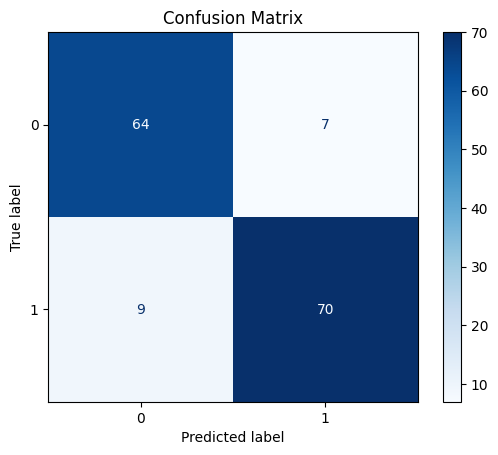

In [116]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Define the KNN model
knn = KNeighborsClassifier(n_neighbors=23)

# Fit the model
knn.fit(X_train, y_train)

# Make predictions on the test set
y_pred = knn.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


### Analysis:
#### Model Performance:

The model demonstrates a high level of accuracy (89%), indicating that it performs well in classifying instances correctly.
The precision and recall values for both classes are high, indicating that the model is both accurate in its predictions and effective at identifying instances of each class.
* Class 0 Analysis: The precision (88%) and recall (90%) for class 0 are both high, suggesting that the model is effective at correctly identifying instances of class 0 and minimizing false positives.

* Class 1 Analysis: The precision (91%) and recall (89%) for class 1 are also high, indicating that the model accurately identifies instances of class 1 and has a low false-negative rate.
    
* Confusion Matrix Insights: The confusion matrix shows a balanced performance between the two classes, with slightly more false positives for class 0 (7) than false negatives for class 1 (9). The number of true positives is high for both classes, indicating the model's effectiveness.

#### Potential Improvements:
While the model performs well, further improvements could be made by increasing the training data size or exploring advanced techniques such as ensemble learning.

#### Conclusion:
The KNN model with k=23 shows strong performance with an overall accuracy of 89%. The high precision, recall, and F1-scores for both classes indicate that the model is reliable and effective for predicting heart disease. The balance in the confusion matrix further supports the robustness of the model. For practical applications, this model can be considered a reliable tool for predicting heart disease, though continuous monitoring and potential refinements could enhance its performance further.






